In [79]:
#import the libraries
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.metrics import r2_score

In [80]:
#read the experimental data
data = pd.read_csv("data.csv")
display(data)

,t(h),X,S,P
0,0,1.70,91.45,0.87
1,1,1.65,89.74,1.77
2,2,1.85,87.94,2.03
3,3,2.80,81.84,4.05
4,4,2.65,74.64,8.18
5,5,3.35,65.85,12.80
6,6,3.30,55.23,15.38
7,7,5.05,45.54,21.10
8,8,4.17,37.96,28.06
9,9,3.90,28.66,33.22


In [81]:
#Definition of kinetic model (Monod)
def monod(z,t):
    #Conversion parameters (experimental)
    Yxs = 0.0434
    Yps = 0.5078
    Ypx = Yps/Yxs

    #Kinetics constants
    umax= 0.10609
    Ks  = 0.42995

    #Assign each variable to a vector z
    X = z[0]
    S = z[1]
    P = z[2]

    #Define the ODE system
    dXdt = umax*S/(Ks+S)*X
    dSdt = -umax*S/(Ks+S)*X/Yxs
    dPdt = umax*S/(Ks+S)*X*Ypx
   
    return [dXdt,dSdt,dPdt]

In [82]:
#Define initial conditions
X0 = data.iloc[0,1]
S0 = data.iloc[0,2]
P0 = data.iloc[0,3]
init = [X0, S0, P0]

In [83]:
#Define the time range of integration
t = data.iloc[:,0]

#Solve the ODE system
y = odeint(monod,init, t)

#Specify the solution for each variable
X = y[:,0]
S = y[:,1]
P = y[:,2]

In [84]:
#Define experimental data
Xexp =  data.iloc[:,1]
Sexp =  data.iloc[:,2]
Pexp =  data.iloc[:,3]

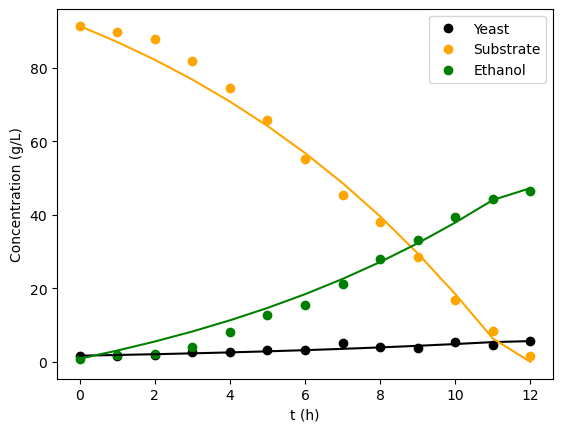

In [85]:
#Graphics
#Experimental points
plt.plot(t, Xexp, 'o', color='black', label = 'Yeast')
plt.plot(t, Sexp, 'o', color='orange',label = 'Substrate')
plt.plot(t, Pexp, 'o', color='green', label = 'Ethanol')

#ODE system model
plt.plot(t, X,'-', color='black')
plt.plot(t, S,'-', color='orange')
plt.plot(t, P,'-', color='green')

#Graphic parameters
plt.xlabel('t (h)')
plt.ylabel('Concentration (g/L)')
plt.legend(loc='best')

Text(0.5, 1.0, 'Estimated vs. observed (Ethanol)')

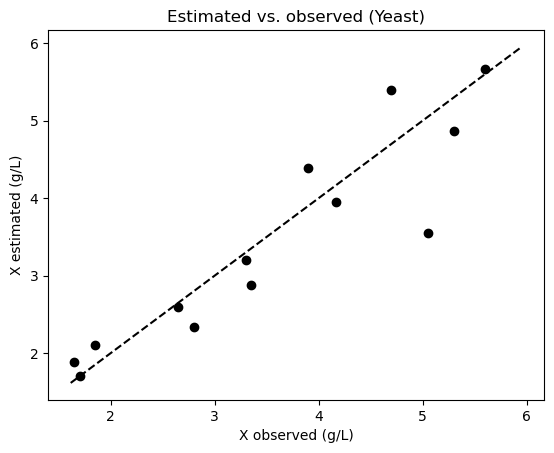

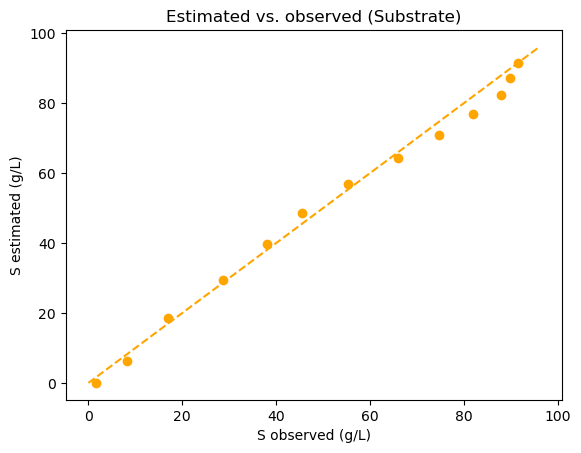

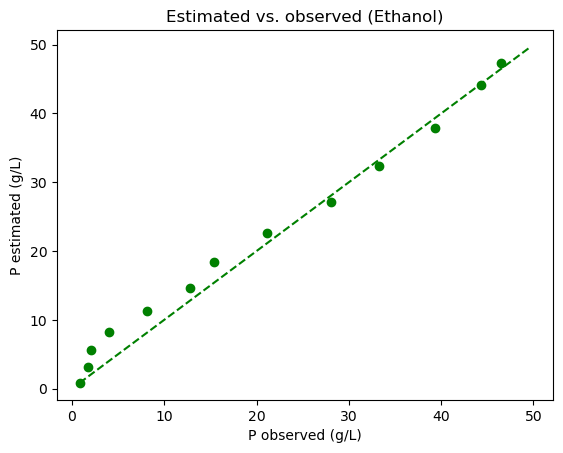

In [86]:
#Estimated vs. observed plots

#Yeast
plt.figure(0)
plt.plot(Xexp, X, 'o', color='black')
plt.plot([min(X)*0.95,max(X)*1.05], [min(X)*0.95,max(X)*1.05], '--', color='black')
#Graphic parameters
plt.xlabel('X observed (g/L)')
plt.ylabel('X estimated (g/L)')
plt.title("Estimated vs. observed (Yeast)")

#Substrate
plt.figure(1)
plt.plot(Sexp, S, 'o', color='orange')
plt.plot([min(S)*0.95,max(S)*1.05], [min(S)*0.95,max(S)*1.05], '--', color='orange')
#Graphic parameters
plt.xlabel('S observed (g/L)')
plt.ylabel('S estimated (g/L)')
plt.title("Estimated vs. observed (Substrate)")

#Product (Ethanol)
plt.figure(2)
plt.plot(Pexp, P, 'o', color='green')
plt.plot([min(P)*0.95,max(P)*1.05], [min(P)*0.95,max(P)*1.05], '--', color='green')
#Graphic parameters
plt.xlabel('P observed (g/L)')
plt.ylabel('P estimated (g/L)')
plt.title("Estimated vs. observed (Ethanol)")

In [87]:
#Statistics
print("X: R² = {:.3f}".format(r2_score(Xexp,X)))
print("S: R² = {:.3f}".format(r2_score(Sexp,S)))
print("P: R² = {:.3f}".format(r2_score(Pexp,P)))

X: R² = 0.835
S: R² = 0.991
P: R² = 0.982


In [88]:
#Calculate the residues
resX = Xexp - X
resS = Sexp - S
resP = Pexp - P


The residues of X are normally distributed. p-value = 0.233 > 0.01
The residues of S are normally distributed. p-value = 0.600 > 0.01
The residues of P are normally distributed. p-value = 0.522 > 0.01


Text(0.5, 0, 'Residues P')

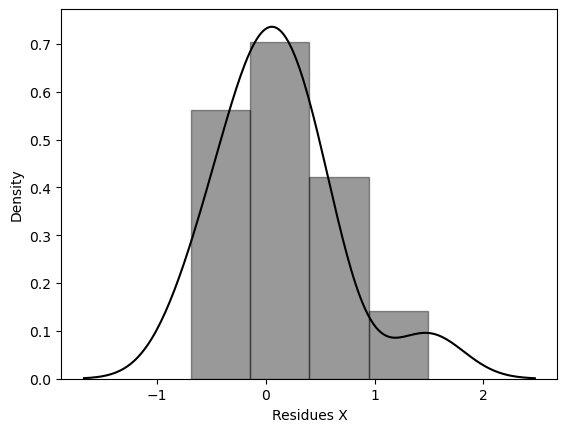

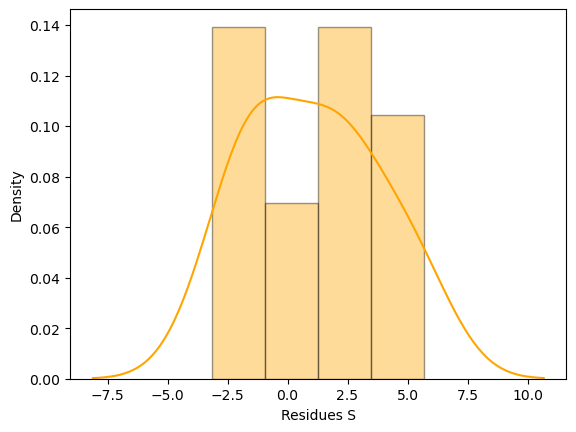

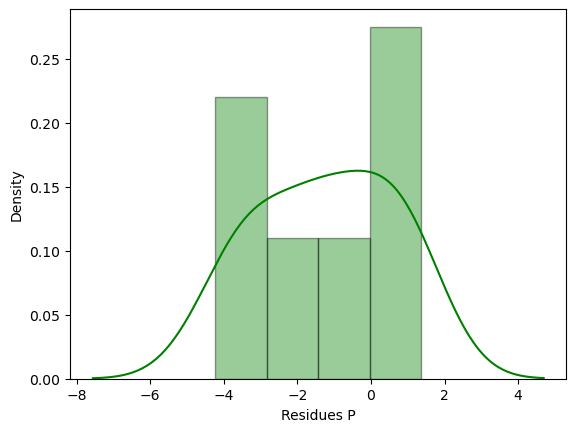

In [98]:
#Histogram residues
warnings.filterwarnings('ignore')

#Specify the confidence level
alfa = 0.01

#plot the residues of X and test normality
plt.figure(4)
sns.distplot(resX, hist = True, kde = True, bins = 4, color = 'black', hist_kws={'edgecolor': 'black'})
hX = stats.shapiro(resX)
if hX[1] < alfa:
    print('The residues of X are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hX[1],alfa))
else:
    print('The residues of X are normally distributed. p-value = {:.3f} > {:.2f}'.format(hX[1],alfa))

plt.xlabel('Residues X')

#plot the residues of S and test normality
plt.figure(5)
sns.distplot(resS, hist = True, kde = True, bins = 4, color = 'orange', hist_kws={'edgecolor': 'black'})
hS = stats.shapiro(resS)
if hS[1] < alfa:
    print('The residues of S are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hS[1],alfa))
else:
    print('The residues of S are normally distributed. p-value = {:.3f} > {:.2f}'.format(hS[1],alfa))
plt.xlabel('Residues S')

#plot the residues of P and test normality
plt.figure(6)
sns.distplot(resP, hist = True, kde = True, bins = 4, color = 'green', hist_kws={'edgecolor': 'black'})
hP = stats.shapiro(resP)
if hP[1] < alfa:
    print('The residues of P are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hP[1],alfa))
else:
    print('The residues of P are normally distributed. p-value = {:.3f} > {:.2f}'.format(hP[1],alfa))
plt.xlabel('Residues P')


Text(0.5, 1.0, 'Residues vs. estimated (Ethanol)')

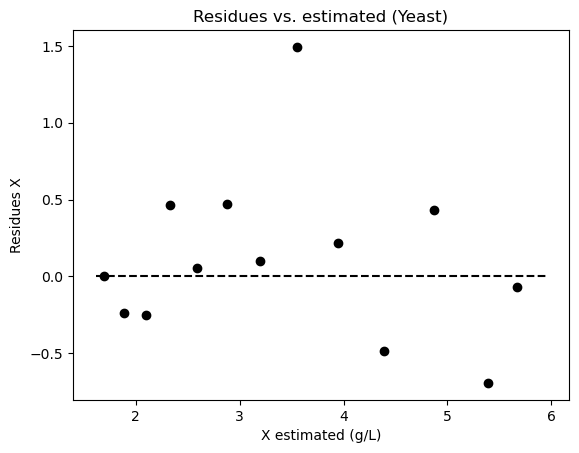

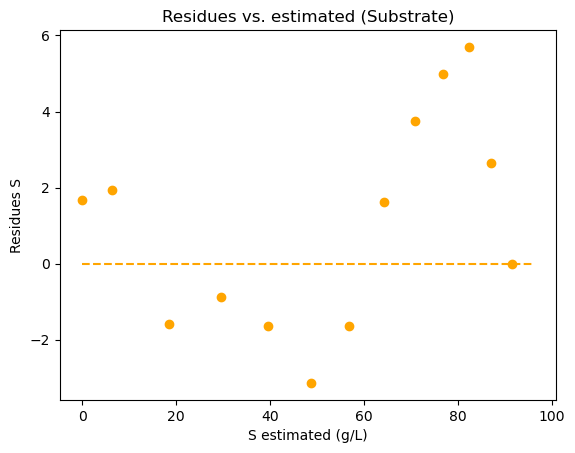

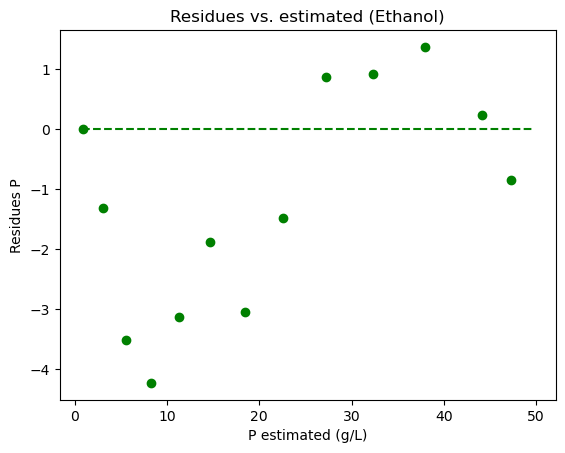

In [30]:
#Residues vs. estimated plots

#Yeast
plt.figure(3)
plt.plot(X,resX, 'o', color='black')
plt.plot([min(X)*0.95,max(X)*1.05], [0,0], '--', color='black')
#Graphic parameters
plt.xlabel('X estimated (g/L)')
plt.ylabel('Residues X')
plt.title("Residues vs. estimated (Yeast)")

#Substrate
plt.figure(4)
plt.plot(S,resS, 'o', color='orange')
plt.plot([min(S)*0.95,max(S)*1.05], [0,0], '--', color='orange')
#Graphic parameters
plt.xlabel('S estimated (g/L)')
plt.ylabel('Residues S')
plt.title("Residues vs. estimated (Substrate)")

#Product (Ethanol)
plt.figure(5)
plt.plot(P,resP, 'o', color='green')
plt.plot([min(P)*0.95,max(P)*1.05], [0,0], '--', color='green')
#Graphic parameters
plt.xlabel('P estimated (g/L)')
plt.ylabel('Residues P')
plt.title("Residues vs. estimated (Ethanol)")